# Semi-Supervised Classifier - MNIST dataset:

The well-known handwritten numbers dataset **MNIST** contains a training set of 60,000 samples and a test set of 10,000 samples, each one of 28x28 pixels (784 pixels). This dataset is available in [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/). For the sake of simplicity, we have reduced the dataset to only 20,000 samples, and the reduced file we have created and we are going to use is *mnist_train_small.csv*.

That is to say, we will work with a dataset of dimensions 20,000x784. Each of the input variables contains an integer value that varies from 0 to 255 indicating the grayscale intensity of the corresponding pixel.

First, we will perform an exploratory data analysis. Then we will design and train a **Semi-Supervised Image Classifier** by mixing the supervised and unsupervised learning techniques previously seen. We start loading the data from the *.csv* file and storing the data and target variables:




In [0]:
import numpy   as np
import scipy   as sc
import sklearn as sk
import matplotlib.pyplot as plt
import pandas  as pd
import seaborn as sb

# We load the dataset from the file with pandas
mnist = pd.read_csv("./sample_data/mnist_train_small.csv", header=None).as_matrix()

# X: sample attributes(20000x784), Y: sample labels (20000x1)
X, Y = mnist[:, 1:], mnist[:, 0:1]

Now, let's use some of the exploratory analysis tools to get a better understanding of the data:

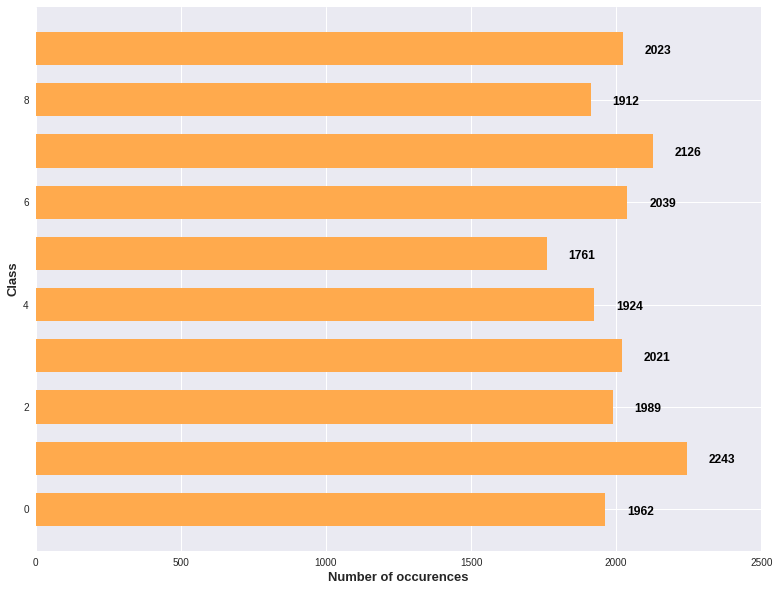

In [2]:
fig, ax = plt.subplots(figsize=(13,10))   

occur = np.bincount(Y.ravel()).tolist()  # Number of occurences for each number class

ax.barh(range(0,10), occur, 0.65, color="#FFAA4D")  # Horizontal bar plot histogram

plt.xlabel('Number of occurences', fontsize='13', fontweight='bold')
plt.xlim(right=2500)
plt.ylabel('Class', fontsize='13', fontweight='bold')

for l, o in enumerate(occur):
    ax.text(o+75, l-0.1, str(o), color='k', fontweight='bold')  # plot occurences in black

plt.show()

As we can see in the figure, the distribution for the different types of numbers is fairly equal, with some predominant classes, such as numbers '1' (2243 samples), as opposed to class '5' (1761 samples).

Each image representing a number is composed of 28x28 =784 pixels, which is the number of dimensions. As we can see, the values taken by each of these pixels oscillate between 0 and 255:


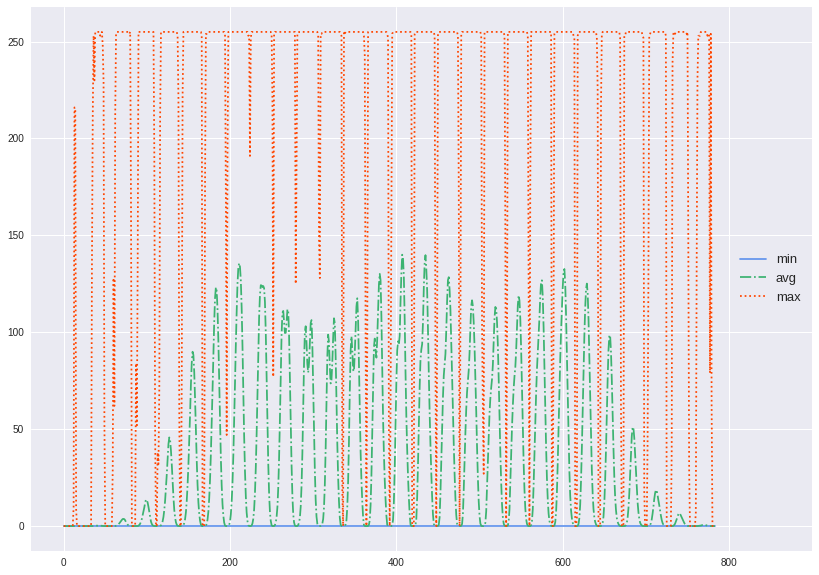

In [3]:
plt.figure(figsize=(14,10))

plt.plot(np.arange(0,784), X.min(axis=0), linestyle="-", c="cornflowerblue", label="min")
plt.plot(np.arange(0,784), X.mean(axis=0), linestyle="-.", c="mediumseagreen", label="avg")
plt.plot(np.arange(0,784), X.max(axis=0), linestyle=":", c="orangered", label="max")
plt.xlim(right=900)

plt.legend(loc='center right', prop={'size': 13})  # Display the legend

plt.show()

 Let's see how correlated these 784 variables are:

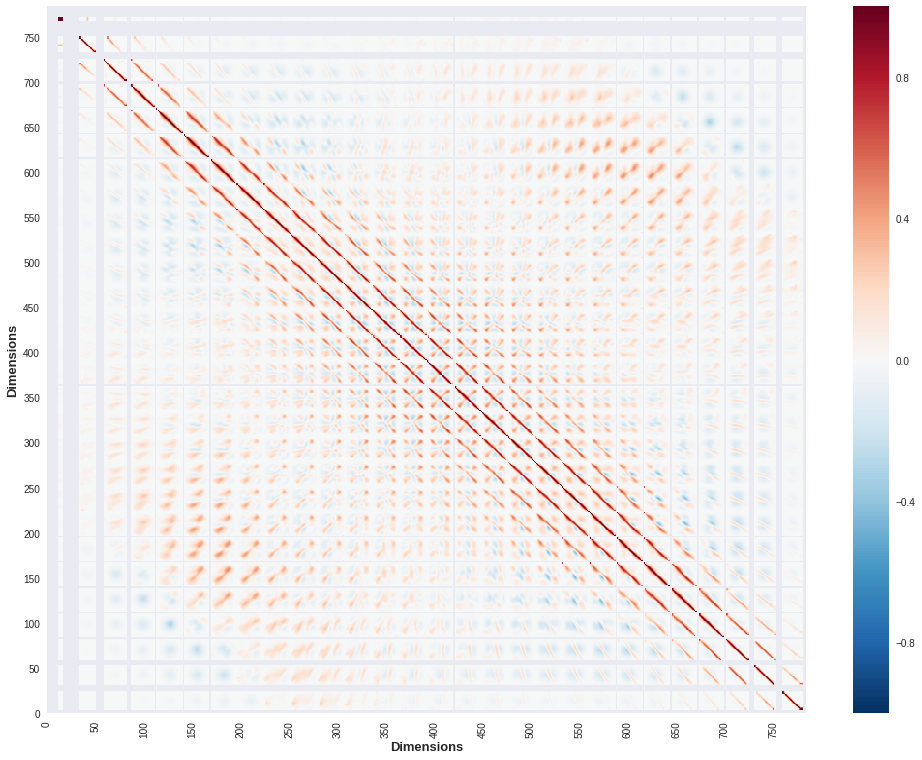

In [4]:
import matplotlib.ticker as ticker

plt.figure(figsize=(17,13))

# Correlation measures how two vectors vary together as they change. There are certain pixels that are always constant (set to 0),
# so it doesn't make sense to track mutual change with this kind of pixels. For this reason, we deliberately supress this warning:
with np.errstate(divide='ignore', invalid='ignore'):  # The standard deviation of this type of mentioned pixels is 0.
  ax = sb.heatmap(np.corrcoef(X.T))  # Correlation matrix

# Show multiples of 50 in the coordinates, since it is impossible to visualize the dimensions from 1 to 784
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.xlabel('Dimensions', fontsize='13', fontweight='bold')
plt.ylabel('Dimensions', fontsize='13', fontweight='bold')

plt.show()

By visualizing the correlation between the flattened number dimensions, we can observe that there exists a clear correlation between many of these variables. It should be noted that grey areas represent non-correlated variables, as it is being compared data that have the same value (image corners, marginal edges, etc.).

Given the existing correlation, we can reduce the number of dimensions to minimize the complexity of data processing. One of the techniques used is **Principal Component Analysis (PCA)**, which reduces dimensionality by creating linear combinations of these dimensions that continue representing the data with a high level of exactitude. We are going to employ the ***PCA*** function from ***sklearn.descomposition***:

In [12]:
from sklearn.decomposition import PCA 

# The amount of variance that needs to be explained is greater than the percentage specified by n_components
X_reduced = PCA(n_components=0.90).fit_transform(X)  # Principal Component Analysis

print("PCA reduces from ", X.shape[1], "columns to only", X_reduced.shape[1], "column.")

PCA reduces from  784 columns to only 87 column.


At this point, we are able to represent 90% of the variance of the data with only 87 columns, which are linear combinations of the 784 that we had initially.

Now, let's compare the value ranges of each "reduced" variable using a **box-plot**:

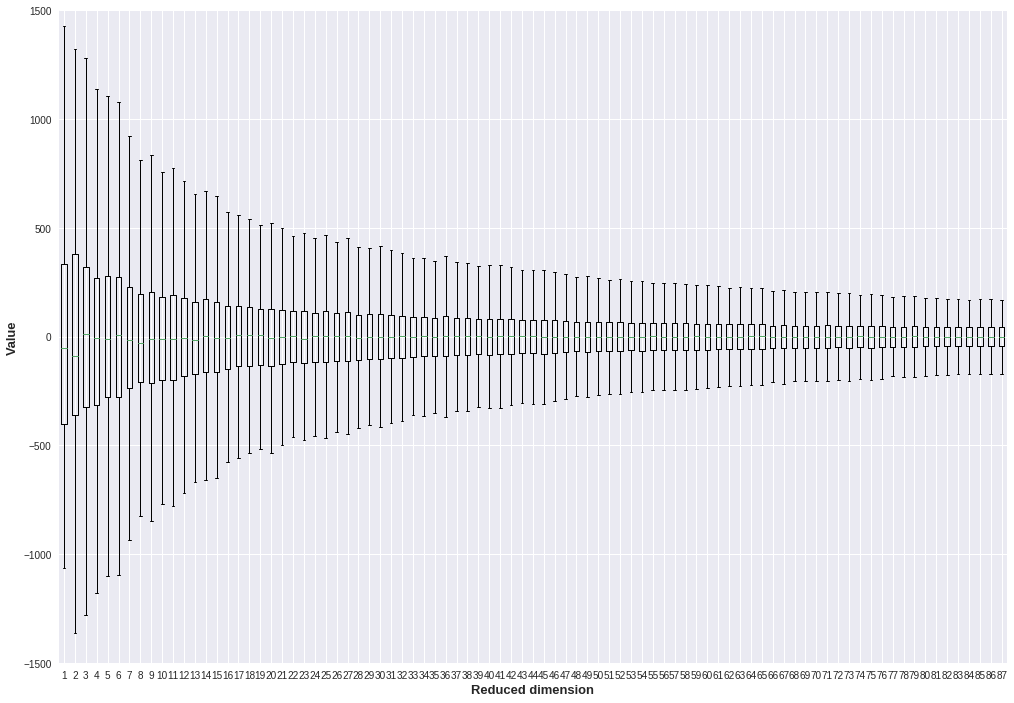

In [6]:
plt.figure(figsize=(17,12))
plt.boxplot(X_reduced)
plt.ylim(top=1500, bottom=-1500)
plt.xlabel('Reduced dimension', fontsize='13', fontweight='bold')
plt.ylabel('Value', fontsize='13', fontweight='bold')
plt.show()

We observe that by applying a reduction in dimensionality, the ranges of the variables are expanded, since they are no longer between 0 and 255, but the medians are approximately aligned around the 0 value.

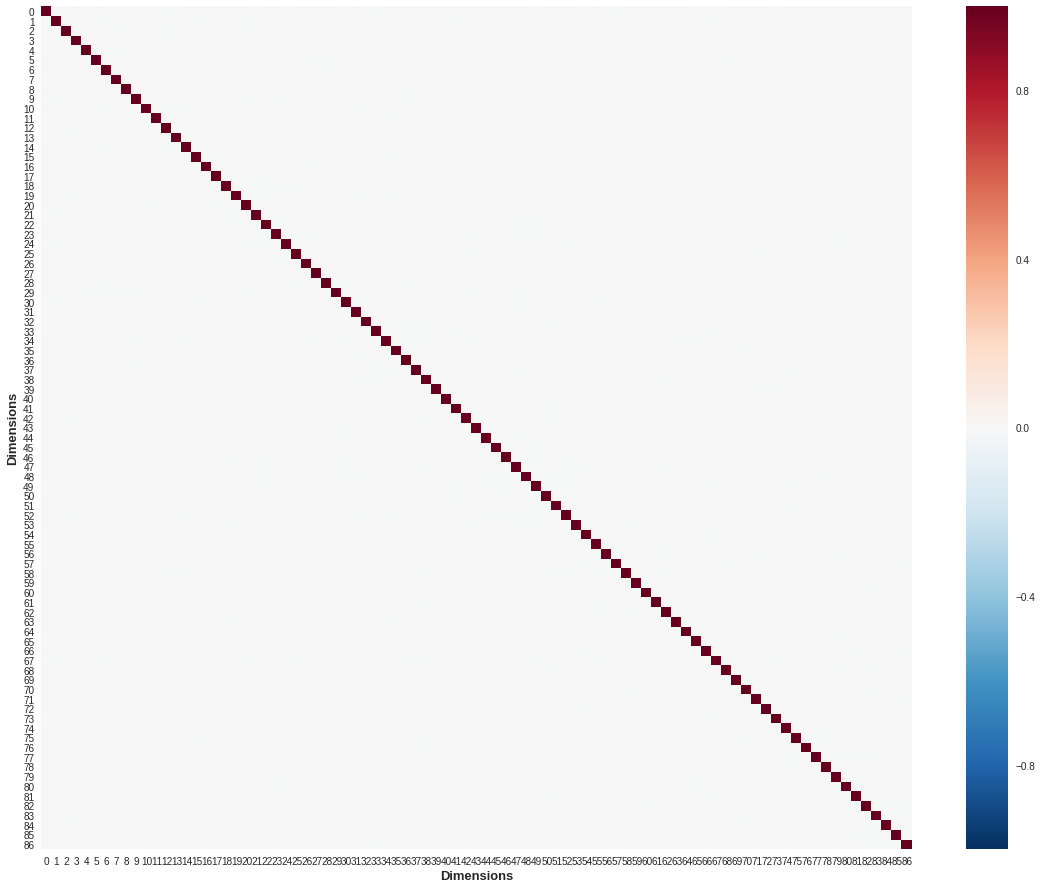

In [7]:
plt.figure(figsize=(19.5,15.5))

sb.heatmap(np.corrcoef(X_reduced.T))  # Correlation matrix

plt.xlabel('Dimensions', fontsize='13', fontweight='bold')
plt.ylabel('Dimensions', fontsize='13', fontweight='bold')

plt.show()

Thus, looking at the new correlation matrix for the reduced data set, it can be established that there is no correlation between the dimensions, as the number of dimensions has been minimized.

---

Once we have explored the nature of our data and preprocessed it to extract the maximum benefit from the analysis, we are going to implement the Semi-Supervised Image Classifier. First, let's use the **K-means** clustering algorithm from ***sklearn.cluster*** module to see if it's possible to identify clusters in the data. We will carry out an unsupervised analysis, and we will use the Elbow method to find the optimal number of k clusters.

In [0]:
from sklearn.cluster import KMeans

max_clusters = 25
nclusters = list(range(2, max_clusters+1))
WCSS = [] # Accuracy for each k-value

for nc in nclusters:
  kmeans = KMeans(init='k-means++', n_clusters=nc)  # k-Means (nc clusters) instance
  kmeans.fit_transform(X_reduced)
  WCSS.append(kmeans.inertia_)

We run k-Means algorithm with different number of clusters, from 2 to 25. To evaluate each method we check the parameter *inertia*, which contains the sum of squared distances of samples to their closest cluster centroid.

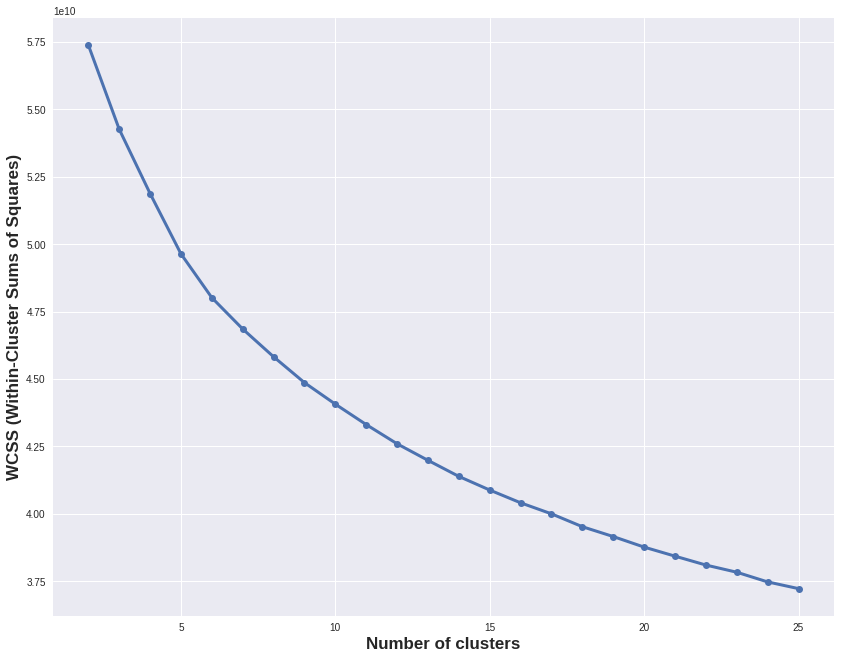

In [9]:
plt.figure(figsize=(14,11))
plt.plot(nclusters, WCSS, "o-", linewidth=3)
plt.xlabel("Number of clusters", fontsize=17, fontweight="bold")
plt.ylabel("WCSS (Within-Cluster Sums of Squares)", fontsize=17, fontweight="bold")
plt.show()

Thus, according to the main rules of the **Elbow method**, the optimum number of clusters would be between **8 and 10**, as they are the furthest perpendicularly points from the line joining the first and last points. We assume then that the number of clusters is 10, since we are aware of the information beforehand, because we know that in the **MNIST** dataset there are 10 different types of numbers (classes).

Now, let's continue with the development of our Semi-Supervised Classifier. The procedure consist of: **labelling 50 random** dataset values, that is, we will randomly select 50 points from the dataset and check its label in the Y vector (target). We will use these 50 labels, 5 for each cluster, to check which is the most frequent label in the identified clusters, and we will assign to all the elements of the cluster that most frequent label. Finally, we evaluate the quality of the predictions comparing them with the original data, calculating the accuracy of the model. All these steps will be repeated by means of a for loop to calculate the average of this metric and thus reduce the effects of randomness when selecting the 50 points:

AVG. Accuracy for Semi-Supervised Classifier (k-Means): 0.5135666666666667


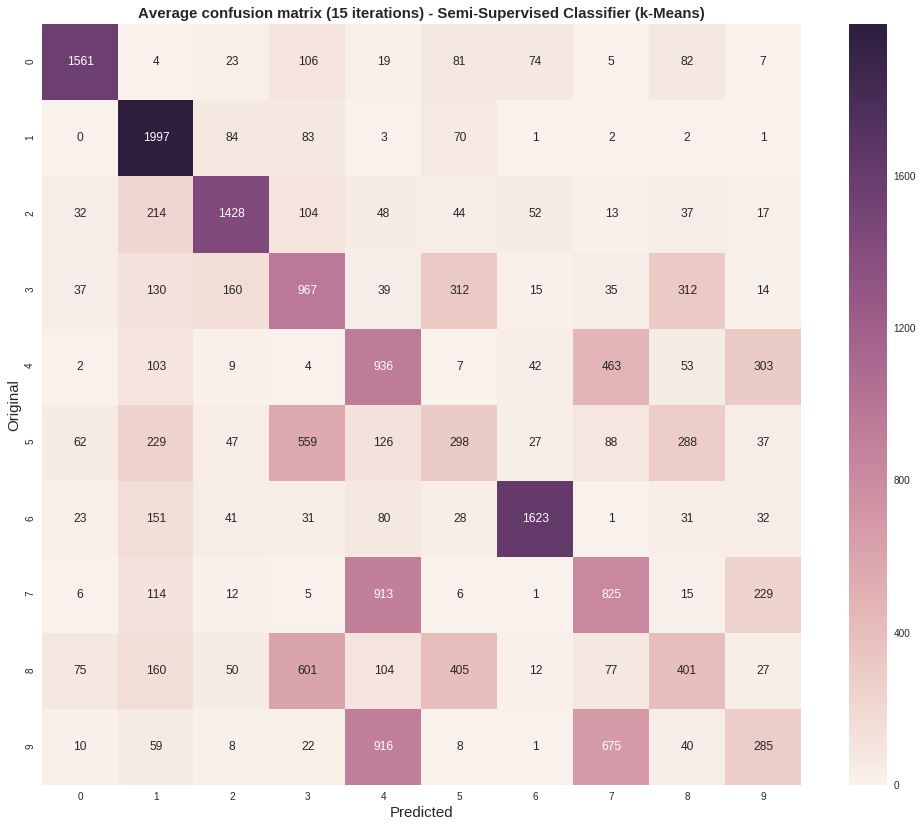

In [10]:
from sklearn.metrics import confusion_matrix

nclust = 10  # We assume the number of clusters is 10
accuracy = []

Y_pred = np.zeros(Y.shape)  # Vector to save the predictions
matConf = np.zeros((10,10), dtype=float)  # Confusion matrix

kmeans = KMeans(init='k-means++', n_clusters=nclust)  # Create 10 cluster k-Means
kmeans.fit_transform(X_reduced)

labels = kmeans.labels_  # Get the labels

it = 15

for i in range(it):  # 15 times

  m = 50  # We will randomly choose 50 samples of our Y vector
  
  # Foreach cluster, we randomly "uncover" the labels of only 5 numbers. Then, we select the most frequent uncovered label
  freq_label_clus = [np.argmax(np.bincount(np.random.choice(Y[labels == c].ravel(), m // nclust))) for c in range(nclust)]

  for c in range(nclust):  # We assign the most common label to all the data in the cluster
    Y_pred[labels == c] = freq_label_clus[c]
    
  #  We calculate accuracy by comparing the predicted Y's with the original Y's
  accuracy.append((np.sum(Y_pred == Y) - m) / Y_pred.shape[0])
  
  matConf+= confusion_matrix(Y, Y_pred)

print("AVG. Accuracy for Semi-Supervised Classifier (k-Means):", np.mean(accuracy))

matConf=matConf/it  # Confusion matrix AVG

plt.figure(figsize=(17,14))
ax = sb.heatmap(matConf, annot=True, fmt=".0f")  # Plot the confusion matrix
ax.set_ylabel('Original', fontsize=15)
ax.set_xlabel('Predicted', fontsize=15)
plt.title("Average confusion matrix (" + str(it) + " iterations) - Semi-Supervised Classifier (k-Means)", fontsize=15, fontweight='bold')
plt.show()

It should be noted that, by spending only resources to train with 0.25% of the data (50 labels of 20,000), we have achieved 53% accuracy. Also, the correlation matrix tells us which predictions our Semi-Supervised Classifier fails most often. For example, it usually tends to predict **4** numbers when them are actually **7**s and **9**s.

Let's check if we can improve the performance of the Semi-Supervised Classifier using other classification model, such as **k-Nearest Neighbors** classifier from ***sklearn.neighbors***:

AVG. Accuracy for k-NN (10 neighbors): 0.9567777777777777


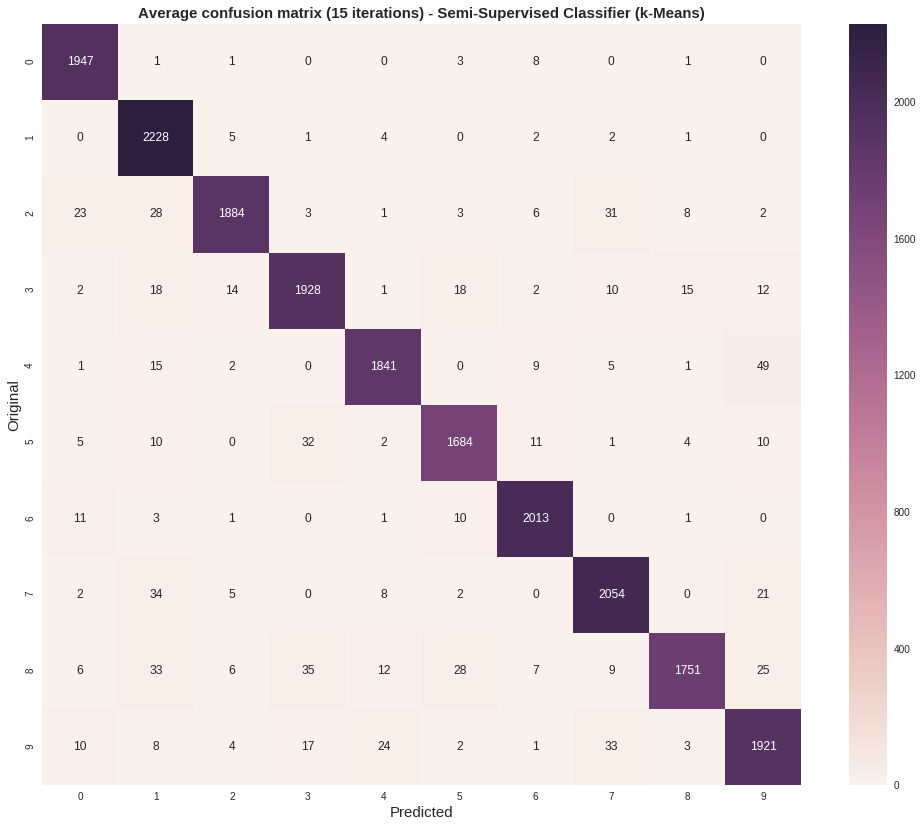

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

accuracy = []

it = 15

matConf = np.zeros((10,10), dtype=float)

for i in range(it):
  
  X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y.ravel(), test_size=0.3)  # Data train/test partition

  knn = KNeighborsClassifier(n_neighbors=10)
  knn.fit(X_train, Y_train)
  accuracy.append(knn.score(X_test, Y_test))
  
  matConf+= confusion_matrix(Y, knn.predict(X_reduced))  

print("AVG. Accuracy for k-NN (10 neighbors):", np.mean(accuracy))

matConf=matConf/it  # Confusion matrix AVG

plt.figure(figsize=(17,14))
ax = sb.heatmap(matConf, annot=True, fmt=".0f")  # Plot the confusion matrix
ax.set_ylabel('Original', fontsize=15)
ax.set_xlabel('Predicted', fontsize=15)
plt.title("Average confusion matrix (" + str(it) + " iterations) - Semi-Supervised Classifier (k-Means)", fontsize=15, fontweight='bold')
plt.show()

The **k-NN**-based model completely outperforms the Semi-Supervised Classifier, and as we can see from the confusion matrix, those failures in MNIST number predictions no longer occur.